In [1]:
%matplotlib inline

morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'

In [2]:
import os
dirname = "/Volumes/simulation_data_2018/protoDC2_v4"
basename_z0p00 = "umachine_color_mock_v4_m000-499.hdf5"
basename_z0p25 = "umachine_color_mock_v4_m000-392.hdf5"
basename_z0p50 = "umachine_color_mock_v4_m000-331.hdf5"
basename_z0p75 = "umachine_color_mock_v4_m000-286.hdf5"
basename_z1p00 = "umachine_color_mock_v4_m000-253.hdf5"

redshift = 0.0
if redshift == 0.0:
    basename = basename_z0p00
elif redshift == 0.25:
    basename = basename_z0p25
elif redshift == 0.5:
    basename = basename_z0p50
elif redshift == 0.75:
    basename = basename_z0p75
if redshift == 1.0:
    basename = basename_z1p00


Lbox = 256.
Lbox_physical = Lbox/(1. + redshift)
Veff = Lbox_physical**3.


fname = os.path.join(dirname, basename)

from astropy.table import Table
mock = Table.read(fname, path='data')
mock['redshift'] = redshift
mock.rename_column('restframe_extincted_sdss_abs_magr', 'um_mag_r_rest')
mock.rename_column('restframe_extincted_sdss_gr', 'um_gr_rest')
mock.rename_column('restframe_extincted_sdss_ri', 'um_ri_rest')
mock['um_mag_g_rest'] = mock['um_gr_rest'] + mock['um_mag_r_rest']

print(mock.keys())

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['source_halo_id', 'target_halo_id', 'target_halo_x', 'target_halo_y', 'target_halo_z', 'target_halo_vx', 'target_halo_vy', 'target_halo_vz', 'target_halo_mass', 'host_halo_mvir', 'upid', 'mpeak', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz', 'obs_sm', 'obs_sfr', 'sfr_percentile', 'um_mag_r_rest', 'um_gr_rest', 'um_ri_rest', 'is_on_red_sequence_gr', 'is_on_red_sequence_ri', 'x', 'vx', 'y', 'vy', 'z', 'vz', 'lightcone_id', 'redshift', 'um_mag_g_rest']


In [3]:
brightest_rband = -24.64
def update_rest_rband(um_r_rest_old, r_rest_old, um_r_rest_new):
    """
    """
    dr = r_rest_old - um_r_rest_old
    new_rest_rband = um_r_rest_new + dr
    return np.where(new_rest_rband < brightest_rband, brightest_rband, new_rest_rband)


In [33]:
from cosmodc2.stellar_mass_remapping import lift_high_mass_mstar

mock['new_mstar'] = lift_high_mass_mstar(
        mock['mpeak'], mock['obs_sm'], mock['redshift'], 
        z_table=[0.25, 0.5, 1], 
        slope_table=[0.5, 0.65, 0.7], pivot_table=[13.25, 13, 12.5])

from cosmodc2.sdss_colors.analytical_magr import magr_monte_carlo2

mock['new_um_mag_r_rest'] = magr_monte_carlo2(mock['new_mstar'], mock['redshift'],
                slope_boost_table=[0, 0.1, 0.2],
                boost_table=[0, -0.5, -1, -1.25],
                beta_z0=2.85, magr_at_m1_z0=-20.2, gamma=2.25)

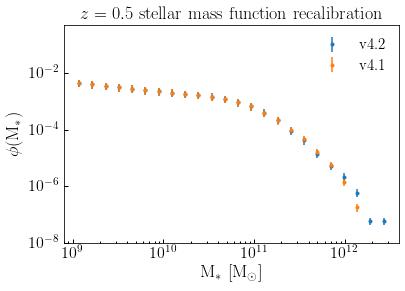

In [34]:
logsm_bins = np.linspace(9, 12.5, 25)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])
sm_bins = 10**logsm_bins
sm_mids = 10**logsm_mids

smf_old = np.zeros_like(logsm_mids)
smf_new = np.zeros_like(logsm_mids)

for i, sm_low, sm_high in zip(range(len(logsm_mids)), sm_bins[:-1], sm_bins[1:]):
    orig_sm_mask = (mock['obs_sm'] > sm_low) & (mock['obs_sm'] < sm_high)
    new_sm_mask = (mock['new_mstar'] > sm_low) & (mock['new_mstar'] < sm_high)
    smf_old[i] = np.count_nonzero(orig_sm_mask)/Veff
    smf_new[i] = np.count_nonzero(new_sm_mask)/Veff
    
fig, ax = plt.subplots(1, 1)

__=ax.loglog()

__=ax.errorbar(sm_mids, smf_new, 0.3*smf_new, fmt='.', 
               label=r'${\rm v4.2}$', color=mblue)
__=ax.errorbar(sm_mids, smf_old, 0.3*smf_old, fmt='.', 
               label=r'${\rm v4.1}$', color=morange)

ylim = ax.set_ylim(1e-8, 0.5)
legend = ax.legend()

xlabel = ax.set_xlabel(r'${\rm M_{\ast}\ [M_{\odot}]}$')
ylabel = ax.set_ylabel(r'$\phi({\rm M_{\ast}})$')
title = ax.set_title(r'$z=0.5\ {\rm stellar\ mass\ function\ recalibration}$')

figname = 'smf_recalibration_v4p2.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [35]:
print(mock.keys())

['source_halo_id', 'target_halo_id', 'target_halo_x', 'target_halo_y', 'target_halo_z', 'target_halo_vx', 'target_halo_vy', 'target_halo_vz', 'target_halo_mass', 'host_halo_mvir', 'upid', 'mpeak', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz', 'obs_sm', 'obs_sfr', 'sfr_percentile', 'um_mag_r_rest', 'um_gr_rest', 'um_ri_rest', 'is_on_red_sequence_gr', 'is_on_red_sequence_ri', 'x', 'vx', 'y', 'vy', 'z', 'vz', 'lightcone_id', 'redshift', 'um_mag_g_rest', 'new_mstar', 'new_um_mag_r_rest']


## Compare cumulative number density to Zehavi+11

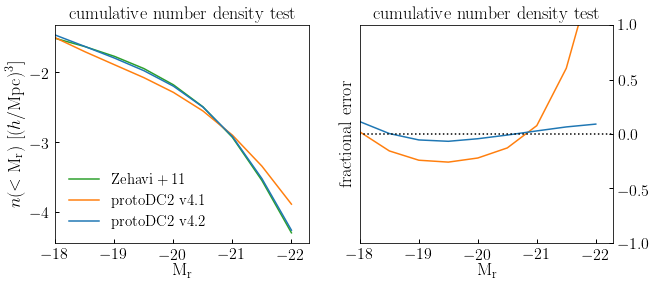

In [36]:
from cosmodc2.sdss_colors import zehavi11_cumulative_nd
lumthresh_h1p0, cumnd_sdss = zehavi11_cumulative_nd()

from cosmodc2.mock_diagnostics import cumulative_nd

volume_v4 = Lbox**3.
protoDC2_littleh = 0.7
cumnd_pdc2_v4p2 = cumulative_nd(mock['new_um_mag_r_rest'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)
cumnd_pdc2_v4p1 = cumulative_nd(mock['um_mag_r_rest'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_sdss), label=r'${\rm Zehavi+11}$', color=mgreen)
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4p1), 
            label=r'${\rm protoDC2\ v4.1}$', color=morange)
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4p2), 
            label=r'${\rm protoDC2\ v4.2}$', color=mblue)

fracdiff_pdc2_v4p1 = (cumnd_pdc2_v4p1 - cumnd_sdss)/cumnd_sdss
fracdiff_pdc2_v4p2 = (cumnd_pdc2_v4p2 - cumnd_sdss)/cumnd_sdss

__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4p1, 
            label=r'${\rm protoDC2\ v4.1}$', color=morange)
__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4p2, 
            label=r'${\rm protoDC2\ v4.2}$', color=mblue)
__=ax2.plot(np.linspace(-100, 100, 100), np.zeros(100), ':', color='k')

legend = ax1.legend()
xlabel = ax1.set_xlabel(r'${\rm M_{r}}$')
xlabel2 = ax2.set_xlabel(r'${\rm M_{r}}$')
ylabel2 = ax2.set_ylabel(r'${\rm fractional\ error}$')
ylabel = ax1.set_ylabel(r'$n(<{\rm M_r})\ [(h/{\rm Mpc})^3]$')
title1 = ax1.set_title(r'${\rm cumulative\ number\ density\ test}$')
title2 = ax2.set_title(r'${\rm cumulative\ number\ density\ test}$')
ax2.yaxis.tick_right()  
xlim1 = ax1.set_xlim(-18, -22.3)
ylim2 = ax2.set_ylim(-1, 1)


## Compare luminosity threshold clustering to Zehavi+11

In [37]:
from cosmodc2.mock_diagnostics import zehavi_wp

period = Lbox
x, y, z, vz = mock['x'], mock['y'], mock['z'], mock['vz']
magr = mock['new_um_mag_r_rest']

rp_mids, wp_v4_19p0 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh)
rp_mids, wp_v4_19p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh)
rp_mids, wp_v4_20p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh)
rp_mids, wp_v4_21p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh)


...calculating wp for 2.66e+05 galaxies and Mr < -19.0
...calculating wp for 1.75e+05 galaxies and Mr < -19.5
...calculating wp for 5.28e+04 galaxies and Mr < -20.5
...calculating wp for 5.00e+03 galaxies and Mr < -21.5


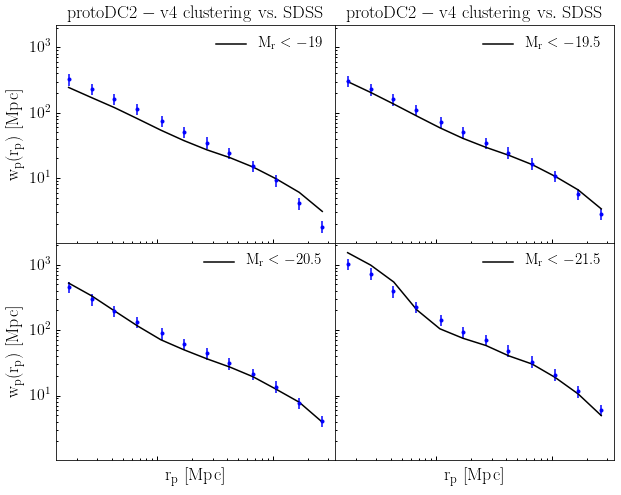

In [38]:
from cosmodc2.sdss_colors.sdss_measurements import rp as rp_zehavi
from cosmodc2.sdss_colors import zehavi11_clustering

wp_zehavi_18p5 = zehavi11_clustering(-18.5)
wp_zehavi_19p0 = zehavi11_clustering(-19.0)
wp_zehavi_19p5 = zehavi11_clustering(-19.5)
wp_zehavi_20p0 = zehavi11_clustering(-20.0)
wp_zehavi_20p5 = zehavi11_clustering(-20.5)
wp_zehavi_21p0 = zehavi11_clustering(-21.0)
wp_zehavi_21p5 = zehavi11_clustering(-21.5)

fig, _axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4
for ax in axes:
    __=ax.loglog()


__=ax1.plot(rp_mids, wp_v4_19p0,  color='k', label=r'${\rm M_{r} < -19}$')
__=ax1.errorbar(rp_zehavi, wp_zehavi_19p0, 0.2*wp_zehavi_19p0, 
               fmt='.', color='blue')

__=ax2.plot(rp_mids, wp_v4_19p5,  color='k', label=r'${\rm M_{r} < -19.5}$')
__=ax2.errorbar(rp_zehavi, wp_zehavi_19p5, 0.2*wp_zehavi_19p5, 
               fmt='.', color='blue')

__=ax3.plot(rp_mids, wp_v4_20p5,  color='k', label=r'${\rm M_{r} < -20.5}$')
__=ax3.errorbar(rp_zehavi, wp_zehavi_20p5, 0.2*wp_zehavi_20p5, 
               fmt='.', color='blue')

__=ax4.plot(rp_mids, wp_v4_21p5,  color='k', label=r'${\rm M_{r} < -21.5}$')
__=ax4.errorbar(rp_zehavi, wp_zehavi_21p5, 0.2*wp_zehavi_21p5, 
               fmt='.', color='blue')

for ax in axes:
    leg = ax.legend()

title1 = ax1.set_title(r'${\rm protoDC2-v4\ clustering\ vs.\ SDSS}$')
title2 = ax2.set_title(r'${\rm protoDC2-v4\ clustering\ vs.\ SDSS}$')

xlabel3 = ax3.set_xlabel(r'${\rm r_p\ [Mpc]}$')
xlabel4 = ax4.set_xlabel(r'${\rm r_p\ [Mpc]}$')
ylabel1 = ax1.set_ylabel(r'${\rm w_p(r_p)\ [Mpc]}$')
ylabel3 = ax3.set_ylabel(r'${\rm w_p(r_p)\ [Mpc]}$')

__=ax1.set_xticklabels([''])
__=ax2.set_xticklabels([''])
